# 피드백 반영

> 이상값들을 제거하고 모형적합을 새로 해보자.

- [**Data Link**](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview)
- [**이전 분석내용**](https://pinkocto.github.io/noteda/posts/2023-04-04-lr-hw1.html#grlivarea)

앞서 분석내용에서 절편을 제거하기 전과 후의 회귀모형의 $R^2$ 값 차이가 이상하리만큼 차이가 컸음. ($R^2:0.5021 \to 0.91836$) 혹시 이상값 때문일까?

In [6]:
options(warn=-1)

library(lmtest) ## bptest, dwtest
library(tidyverse)
library(janitor)
library("gridExtra")

library(corrplot)
library(ggplot2)
library(scales)
library(ggrepel)

In [7]:
df <- read.csv('./house_price/train.csv')
head(df)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,⋯,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
,<int>,<int>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<int>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<int>
1,1,60,RL,65,8450,Pave,NA,Reg,Lvl,AllPub,⋯,0,NA,NA,NA,0,2,2008,WD,Normal,208500
2,2,20,RL,80,9600,Pave,NA,Reg,Lvl,AllPub,⋯,0,NA,NA,NA,0,5,2007,WD,Normal,181500
3,3,60,RL,68,11250,Pave,NA,IR1,Lvl,AllPub,⋯,0,NA,NA,NA,0,9,2008,WD,Normal,223500
4,4,70,RL,60,9550,Pave,NA,IR1,Lvl,AllPub,⋯,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
5,5,60,RL,84,14260,Pave,NA,IR1,Lvl,AllPub,⋯,0,NA,NA,NA,0,12,2008,WD,Normal,250000
6,6,50,RL,85,14115,Pave,NA,IR1,Lvl,AllPub,⋯,0,NA,MnPrv,Shed,700,10,2009,WD,Normal,143000


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


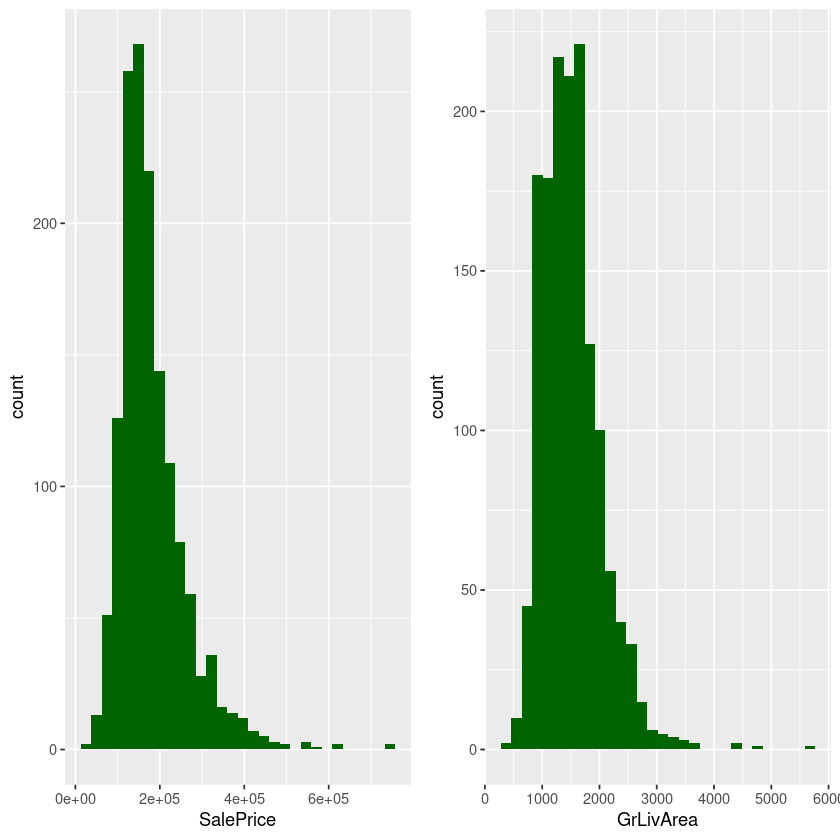

In [5]:
p1 <- ggplot(data=df, aes(x=SalePrice)) +
        geom_histogram(fill='darkgreen')
        # scale_x_continuous(breaks= seq(0, 800000, by=100000), labels = comma)
p2 <- ggplot(data=df, aes(x=GrLivArea)) +
        geom_histogram(fill='darkgreen')

grid.arrange(p1, p2, ncol=2)

- 생각해보니까 위의 히스토그램만 봐도 집값이 이상적으로 매우 높은 관측치들이 몇몇 보임. (매우 비싼 고급 주택?)

`geom_smooth()` using formula = 'y ~ x'


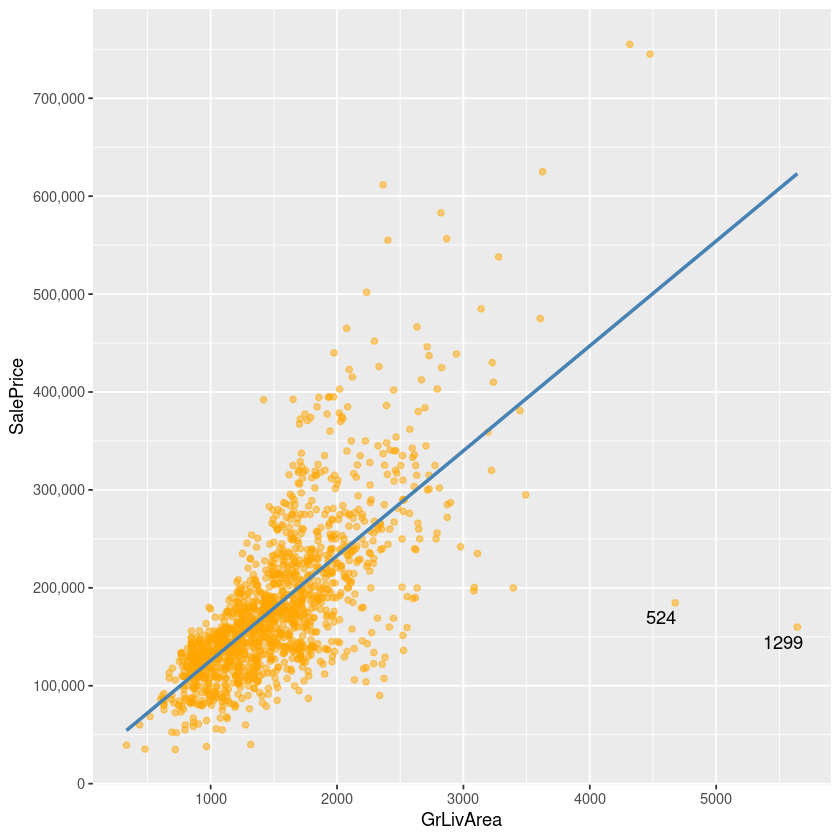

In [9]:
ggplot(data = df[!is.na(df$SalePrice), ], 
       aes(x = GrLivArea, y = SalePrice)) +
  geom_point(col='orange', alpha=0.5) +
  geom_smooth(method = "lm", se = F, color = "steelblue") +
  scale_y_continuous(breaks = seq(0, 800000, by=100000), labels = comma) +
  geom_text_repel(aes(label = ifelse(df$GrLivArea[!is.na(df$SalePrice)] > 4500,
                                     rownames(df), '')))

실거주면적이 $4000\tt{sqft}$ (약 112평) 이상인데 $200,000$ (2억 6천만원)달러??

In [8]:
df1 <- df[c('SalePrice','GrLivArea')]
head(df1)

,SalePrice,GrLivArea
,<int>,<int>
1,208500,1710
2,181500,1262
3,223500,1786
4,140000,1717
5,250000,2198
6,143000,1362


# Remove Outlier

In [10]:
summary(df1)

   SalePrice        GrLivArea   
 Min.   : 34900   Min.   : 334  
 1st Qu.:129975   1st Qu.:1130  
 Median :163000   Median :1464  
 Mean   :180921   Mean   :1515  
 3rd Qu.:214000   3rd Qu.:1777  
 Max.   :755000   Max.   :5642  

In [14]:
df_out <- df1[-c(524, 1299),]

## 선형회귀모형 적합 (model1)

In [16]:
model1 <- lm(SalePrice ~ GrLivArea, df_out)
model1


Call:
lm(formula = SalePrice ~ GrLivArea, data = df_out)

Coefficients:
(Intercept)    GrLivArea  
       7169          115  


In [17]:
summary(model1)


Call:
lm(formula = SalePrice ~ GrLivArea, data = df_out)

Residuals:
    Min      1Q  Median      3Q     Max 
-197730  -29815    -337   23239  332534 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 7168.970   4432.501   1.617    0.106    
GrLivArea    115.040      2.782  41.358   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 53920 on 1456 degrees of freedom
Multiple R-squared:  0.5402,	Adjusted R-squared:  0.5399 
F-statistic:  1710 on 1 and 1456 DF,  p-value: < 2.2e-16


In [76]:
anova(model1)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
GrLivArea,1,4.973669e+12,4.973669e+12,1710.444,6.591113e-248
Residuals,1456,4.233790e+12,2.907823e+09,NA,NA


## 선형회귀모형 적합 (절편X, model2)

In [18]:
model2 <- lm(SalePrice ~ 0 + GrLivArea, df_out)
model2


Call:
lm(formula = SalePrice ~ 0 + GrLivArea, data = df_out)

Coefficients:
GrLivArea  
    119.3  


In [19]:
summary(model2)


Call:
lm(formula = SalePrice ~ 0 + GrLivArea, data = df_out)

Residuals:
    Min      1Q  Median      3Q     Max 
-205038  -30039    1205   24581  329621 

Coefficients:
          Estimate Std. Error t value Pr(>|t|)    
GrLivArea 119.3044     0.8867   134.5   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 53950 on 1457 degrees of freedom
Multiple R-squared:  0.9255,	Adjusted R-squared:  0.9255 
F-statistic: 1.81e+04 on 1 and 1457 DF,  p-value: < 2.2e-16


In [77]:
aov(model2)

Call:
   aov(formula = model2)

Terms:
                   GrLivArea    Residuals
Sum of Squares  5.269620e+13 4.241397e+12
Deg. of Freedom            1         1457

Residual standard error: 53954.13
Estimated effects are balanced

## Summary

절편을 제거한 것이 회귀모형 설명력에 큰 영향이 있는걸까?

여전히 절편을 제거한 후에 모형의 설명력 차이가 크다.

이전 분석내용과 차이점은 이상치를 제거하기 전보다 설명력이 좀 더 좋아졌다는 것이다.

In [35]:
col <- c('변수','스케일링','변수변환','변동사항', 'R2')
score <- as.matrix(col) 
dim(score) <- c(1,5)
score

변수,스케일링,변수변환,변동사항,R2


In [74]:
score <- matrix(0, ncol=6, nrow=4, byrow=T)
colnames(score) <- c('변수','스케일링','변수변환','이상치제거','변동사항', 'R2')

In [75]:
score[1,] <- c('집값, 실거주면적','X','X','X','단순선형회귀(절편O)',0.5021)
score[2,] <- c('집값, 실거주면적','X','X','X','단순선형회귀(절편X)',0.9186)
score[3,] <- c('집값, 실거주면적','X','X','O','단순선형회귀(절편O) + 이상치제거',0.5402)
score[4,] <- c('집값, 실거주면적','X','X','O','단순선형회귀(절편X) + 이상치제거',0.9255)
score

변수,스케일링,변수변환,이상치제거,변동사항,R2
"집값, 실거주면적",X,X,X,단순선형회귀(절편O),0.5021
"집값, 실거주면적",X,X,X,단순선형회귀(절편X),0.9186
"집값, 실거주면적",X,X,O,단순선형회귀(절편O) + 이상치제거,0.5402
"집값, 실거주면적",X,X,O,단순선형회귀(절편X) + 이상치제거,0.9255


# 변수변환

> 지금부터 분석할 데이터는 이상치가 제거된 데이터임. (`df_out.csv`)

In [79]:
df1 %>% colnames

[1] "SalePrice" "GrLivArea"

price변수에 로그변환을 시켜주자.

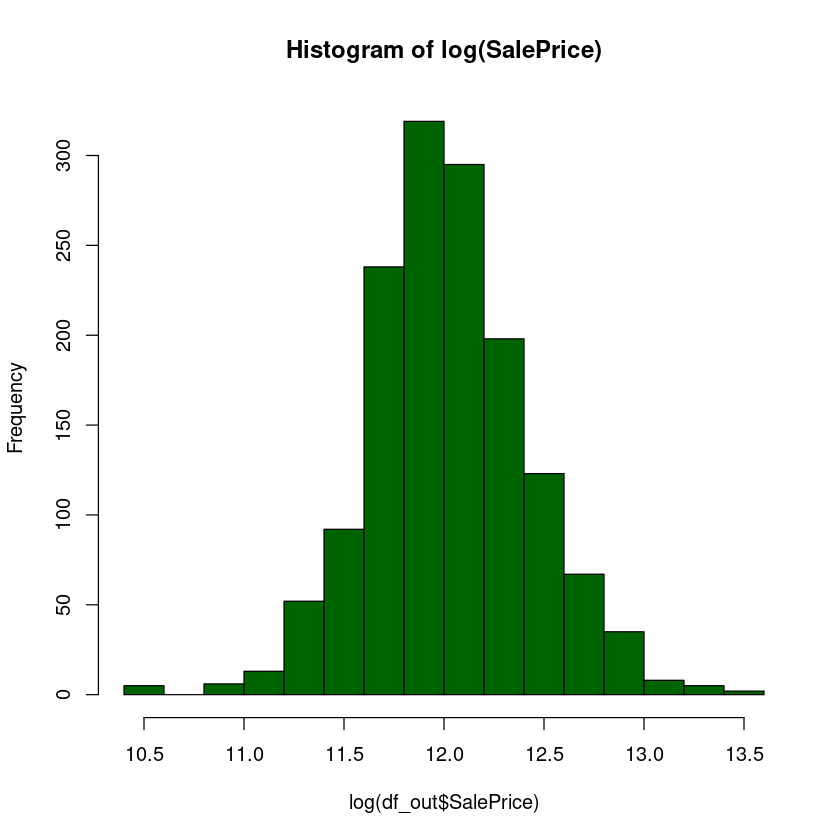

In [88]:
hist(log(df_out$SalePrice), col='darkgreen', main='Histogram of log(SalePrice)')

In [90]:
log(df_out$SalePrice) %>% mean()

[1] 12.02401

- 로그변환 전의 분포와는 달리 skew가 완화되어 어느정도 정규분포를 따르는 것 같음..

In [93]:
df_log <- df_out
df_log$SalePrice <- log(df_out$SalePrice)
df_log %>% head()

,SalePrice,GrLivArea
,<dbl>,<int>
1,12.24769,1710
2,12.10901,1262
3,12.31717,1786
4,11.84940,1717
5,12.42922,2198
6,11.87060,1362


- df_out은 변동 X (원본 그대로)

## 절편 있는 회귀모형 (model3)

In [95]:
model3 <- lm(SalePrice ~ GrLivArea, df_log)
model3


Call:
lm(formula = SalePrice ~ GrLivArea, data = df_log)

Coefficients:
(Intercept)    GrLivArea  
  1.116e+01    5.708e-04  


In [96]:
summary(model3)


Call:
lm(formula = SalePrice ~ GrLivArea, data = df_log)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.31695 -0.14499  0.03338  0.16232  0.90721 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 1.116e+01  2.263e-02  493.23   <2e-16 ***
GrLivArea   5.708e-04  1.420e-05   40.19   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2753 on 1456 degrees of freedom
Multiple R-squared:  0.5259,	Adjusted R-squared:  0.5256 
F-statistic:  1615 on 1 and 1456 DF,  p-value: < 2.2e-16


## 절편없는 회귀모형 (model4)

In [97]:
model4 <- lm(SalePrice ~ 0 + GrLivArea, df_log)
model4


Call:
lm(formula = SalePrice ~ 0 + GrLivArea, data = df_log)

Coefficients:
GrLivArea  
  0.00721  


In [98]:
summary(model4)


Call:
lm(formula = SalePrice ~ 0 + GrLivArea, data = df_log)

Residuals:
     Min       1Q   Median       3Q      Max 
-18.7523  -0.5975   1.5293   3.6004   8.1707 

Coefficients:
           Estimate Std. Error t value Pr(>|t|)    
GrLivArea 7.210e-03  5.864e-05     123   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.568 on 1457 degrees of freedom
Multiple R-squared:  0.9121,	Adjusted R-squared:  0.912 
F-statistic: 1.512e+04 on 1 and 1457 DF,  p-value: < 2.2e-16


## Summary

이상값 제거 + 로그변환 까지 한 결과를 이전 분석내용과 비교한 결과는 다음과 같다.

In [99]:
score <- matrix(0, ncol=6, nrow=6, byrow=T)
colnames(score) <- c('변수','스케일링','변수변환','이상치제거','변동사항', 'R2')

In [106]:
score[1,] <- c('집값, 실거주면적','X','X','X','단순선형회귀(절편O)',0.5021)
score[2,] <- c('집값, 실거주면적','X','X','X','단순선형회귀(절편X)',0.9186)
score[3,] <- c('집값, 실거주면적','X','X','O','단순선형회귀(절편O) + 이상치제거',0.5402)
score[4,] <- c('집값, 실거주면적','X','X','O','단순선형회귀(절편X) + 이상치제거',0.9255)
score[5,] <- c('집값, 실거주면적','X','O','O','단순선형회귀(절편X) + 이상치제거',0.5259)
score[6,] <- c('집값, 실거주면적','X','O','O','단순선형회귀(절편X) + 이상치제거',0.9120)

In [107]:
score

변수,스케일링,변수변환,이상치제거,변동사항,R2
"집값, 실거주면적",X,X,X,단순선형회귀(절편O),0.5021
"집값, 실거주면적",X,X,X,단순선형회귀(절편X),0.9186
"집값, 실거주면적",X,X,O,단순선형회귀(절편O) + 이상치제거,0.5402
"집값, 실거주면적",X,X,O,단순선형회귀(절편X) + 이상치제거,0.9255
"집값, 실거주면적",X,O,O,단순선형회귀(절편X) + 이상치제거,0.5259
"집값, 실거주면적",X,O,O,단순선형회귀(절편X) + 이상치제거,0.912


# 잔차분석

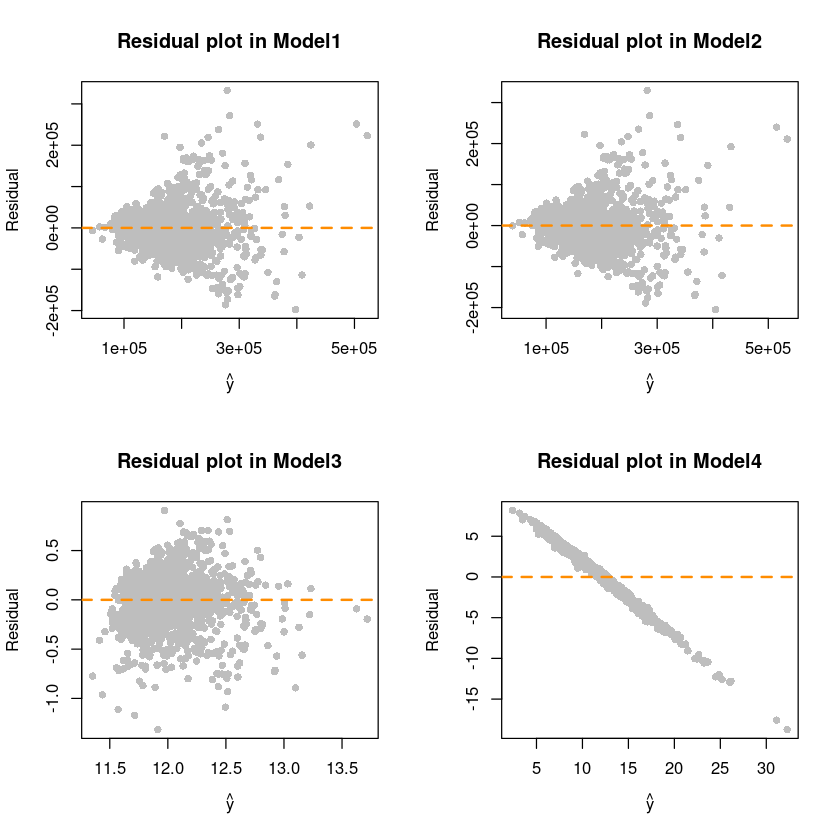

In [113]:
## Model1 residual plot
par(mfrow=c(2,2))
plot(fitted(model1),resid(model1), col = 'grey', pch=16, 
     xlab = expression(hat(y)),
     ylab = "Residual",
     main = "Residual plot in Model1")
abline(h=0, col='darkorange', lty=2, lwd=2)

plot(fitted(model2),resid(model2), col = 'grey', pch=16, 
     xlab = expression(hat(y)),
     ylab = "Residual",
     main = "Residual plot in Model2")
abline(h=0, col='darkorange', lty=2, lwd=2)

plot(fitted(model3),resid(model3), col = 'grey', pch=16, 
     xlab = expression(hat(y)),
     ylab = "Residual",
     main = "Residual plot in Model3")
abline(h=0, col='darkorange', lty=2, lwd=2)

plot(fitted(model4),resid(model4), col = 'grey', pch=16, 
     xlab = expression(hat(y)),
     ylab = "Residual",
     main = "Residual plot in Model4")
abline(h=0, col='darkorange', lty=2, lwd=2)

- Model4 뭔가 이상하다... 로그변환 하면 안되나..?
- 절편이 없는 회귀모형은 bptest가 안된다. $\to$ 왤까???
- bptest가 안되더라도 model4의 residual plot은 매우 이상함.

In [118]:
bptest(model2)

ERROR: Error in bptest(model2): the auxiliary variance regression requires at least an intercept and a regressor


In [117]:
library(lmtest) ## bptest, dwtest
bptest(model4)

ERROR: Error in bptest(model4): the auxiliary variance regression requires at least an intercept and a regressor
